In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from util import getData
%matplotlib inline

In [2]:
X_train, X_test, y_train, y_test = getData()

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32633, 2304)
(4093, 2304)
(32633,)
(4093,)


In [7]:
N = X_train.shape[0]
D = X_train.shape[1]

## simple autoencoder

In [9]:
from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 500

input_img = Input(shape=(D,)) # 入力層の定義
encoded = Dense(encoding_dim, activation='relu')(input_img) # 　中間層の定義
decoded = Dense(D, activation='sigmoid')(encoded) # 出力層の定義
autoencoder = Model(input=input_img, output=decoded) # モデルの生成

###### encoderとdecoderを別々で定義して準備しておく

In [12]:
encoder = Model(input=input_img, output=encoded) # inputをencodeしたものにマッピングする
encoded_input = Input(shape=(encoding_dim,)) #  encoder層の入れ物準備
decoder_layer = autoencoder.layers[-1] # autoencoderの最終層のみ取り出す
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input)) # decoderのモデル作成

training

In [15]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [16]:
autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Train on 32633 samples, validate on 4093 samples
Epoch 1/50
32633/32633 [==============================] - 27s - loss: 0.6892 - val_loss: 0.6833
Epoch 2/50
32633/32633 [==============================] - 26s - loss: 0.6772 - val_loss: 0.6733
Epoch 3/50
32633/32633 [==============================] - 28s - loss: 0.6667 - val_loss: 0.6626
Epoch 4/50
32633/32633 [==============================] - 27s - loss: 0.6563 - val_loss: 0.6539
Epoch 5/50
32633/32633 [==============================] - 24s - loss: 0.6490 - val_loss: 0.6484
Epoch 6/50
32633/32633 [==============================] - 25s - loss: 0.6444 - val_loss: 0.6445
Epoch 7/50
32633/32633 [==============================] - 27s - loss: 0.6410 - val_loss: 0.6414
Epoch 8/50
32633/32633 [==============================] - 25s - loss: 0.6381 - val_loss: 0.6387
Epoch 9/50
32633/32633 [==============================] - 28s - loss: 0.6354 - val_loss: 0.6363
Epoch 10/50
32633/32633 [==============================] - 23s - loss: 0.6330 - val_los

In [17]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs) # autoencoder.predict(X_test)　でもOK

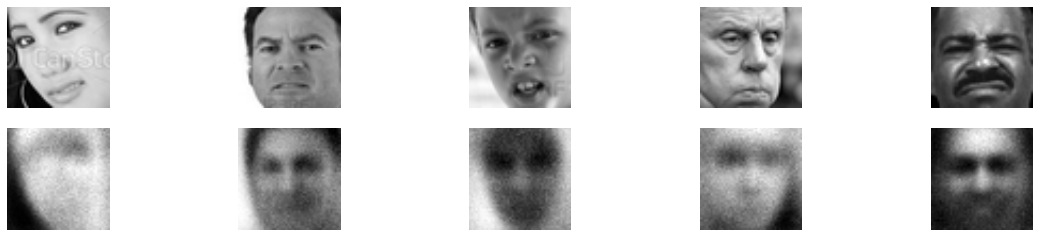

In [24]:
n = 5  # 写真の数
plt.figure(figsize=(20, 4))
for i in range(n):
    # 元画像
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 復元画像
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

poor reconstruction。復元精度をあげようと思ったら、層を深くする、convolution層を入れるなどの対応が考えられるが、今回はここまで。

## denoising autoencoder(MNIST)

ここから手書き数字の判別問題を扱います。(結果がわかりやすく出たため。データ構造などは今までとほぼ同じです。)

In [105]:
from keras.datasets import mnist

(x_train, y_train_mnist), (x_test, y_test_mnist) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# ノイズを加える
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) # 上限値と下限値を設定 (上でノイズを加えてしまうので)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) # 上限値と下限値を設定 (上でノイズを加えてしまうので)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

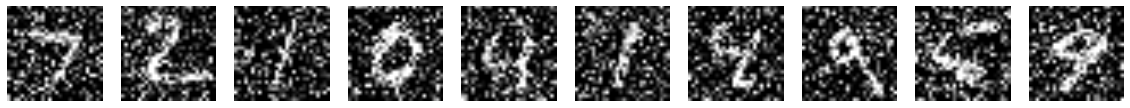

In [53]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ノイジーになった

In [93]:
input_img

<tf.Tensor 'input_8:0' shape=(?, 784) dtype=float32>

In [92]:
encoding_dim = 32

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
# autoencoder = Model(input=input_img, output=decoded)

In [55]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [56]:
autoencoder.fit(x_train_noisy, x_train, nb_epoch=50, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s - loss: 0.3406 - val_loss: 0.2677
Epoch 2/50
60000/60000 [==============================] - 6s - loss: 0.2663 - val_loss: 0.2639
Epoch 3/50
60000/60000 [==============================] - 6s - loss: 0.2615 - val_loss: 0.2571
Epoch 4/50
60000/60000 [==============================] - 6s - loss: 0.2521 - val_loss: 0.2447
Epoch 5/50
60000/60000 [==============================] - 5s - loss: 0.2389 - val_loss: 0.2311
Epoch 6/50
60000/60000 [==============================] - 6s - loss: 0.2267 - val_loss: 0.2199
Epoch 7/50
60000/60000 [==============================] - 5s - loss: 0.2163 - val_loss: 0.2103
Epoch 8/50
60000/60000 [==============================] - 6s - loss: 0.2076 - val_loss: 0.2023
Epoch 9/50
60000/60000 [==============================] - 6s - loss: 0.2003 - val_loss: 0.1956
Epoch 10/50
60000/60000 [==============================] - 6s - loss: 0.1941 - val_loss: 0.1899

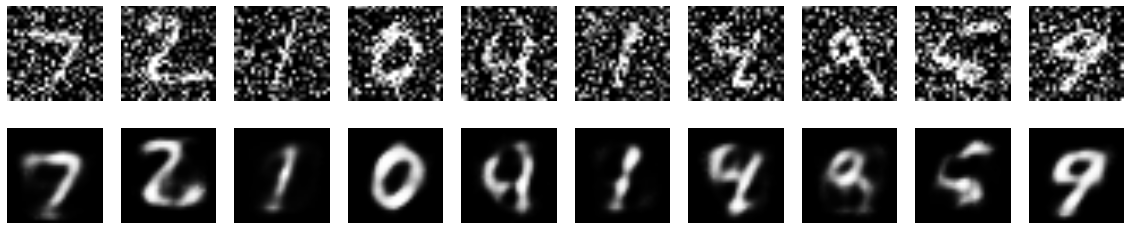

In [57]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ノイズが取れてることがわかる

## t-SNEによる可視化

##### 中間層を取り出す

In [94]:
encoder_middle = Model(input=input_img, output=encoded) # 入力層から中間層を取り出す。

In [97]:
x_test_middle = encoder_middle.predict(x_test) 

In [98]:
x_test_middle.shape

(10000, 32)

##### t-SNEによる可視化を行う。

In [103]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
tsne_result = model.fit_transform(x_test_middle) 

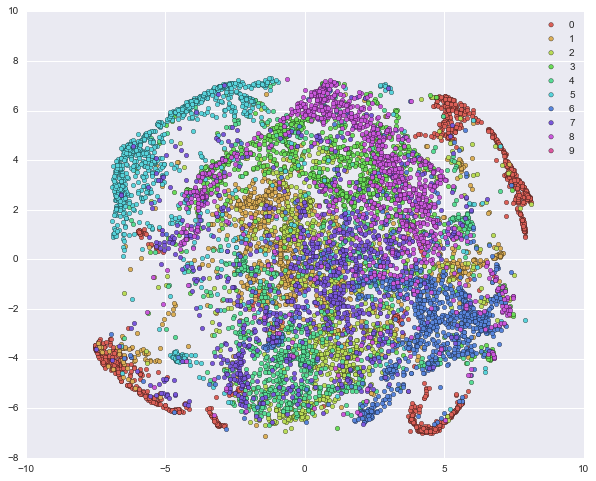

In [107]:
label_map = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
color_map = sns.color_palette("hls",10)
plt.figure(figsize=(10,8))
for i in range(10):
    idx = y_test_mnist == i+1
    plt.scatter(tsne_result[idx,0], tsne_result[idx,1], label=label_map[i], c=color_map[i])
    
plt.legend()

In [114]:
# from mpld3 import show_d3, fig_to_d3, plugins
# label_map = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# color_map = sns.color_palette("hls",10)
# plt.figure(figsize=(10,8))
# for i in range(10):
#     idx = y_test_mnist == i+1
#     plt.scatter(tsne_result[idx,0], tsne_result[idx,1], label=label_map[i], c=color_map[i])
    
# plt.legend()
# show_d3()